In [25]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
load_dotenv()

True

In [26]:
model = ChatOpenAI()

In [27]:
class sentimentschema(BaseModel):
    sentiment: Literal["Postive", "Negative"] = Field(description="Sentiment of the review")
    
class diagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')    

In [28]:
stracture_model = model.with_structured_output(sentimentschema)
stracture_model2 = model.with_structured_output(diagnosisSchema)

c:\Users\shahz\miniconda3\envs\genai\Lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [29]:
prompt = "What is the sentiment of follwing review -: This is not good game!"
stracture_model.invoke(prompt)

sentimentschema(sentiment='Negative')

In [30]:
class Reviewstate(TypedDict):
    review: str
    sentiment: Literal["Postive", "Negative"]
    diagnosis: str
    response: str

In [ ]:
def find_sentiment(state:Reviewstate):
    prompt = f'For the following review find out the sentiment {state["review"]}'
    find_setiment = stracture_model.invoke(prompt).sentiment
    return {"sentiment": find_setiment}

def check_sentiment(state: Reviewstate)->Literal["postive_response", "run_diagnosis"]:
    if state['sentiment'] == 'Postive':
        return "postive_response"
    else:
        return "run_diagnosis"
def postive_response(state:Reviewstate):
    prompt = f'Write a warm thank-you message in response to this review: \n\n {state["review"]}. Also, kindly ask the user to leave feedback on our website.'
    response = model.invoke(prompt).content
    return {'response': response}

def run_diagnosis(state: Reviewstate):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = stracture_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: Reviewstate):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [32]:
graph = StateGraph(Reviewstate)
graph.add_node('find_sentiment',find_sentiment)
graph.add_node('postive_response',postive_response)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('negative_response',negative_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('postive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)
workflow = graph.compile()


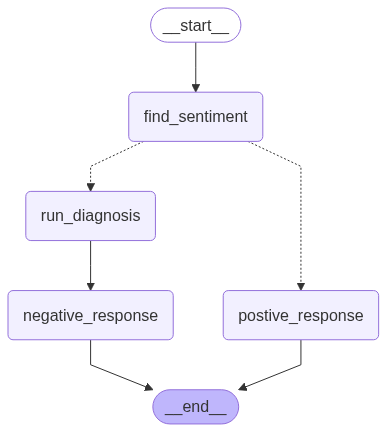

In [33]:
workflow

In [34]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

KeyError: 'setiment'